생성된 데이터 저장 완료: GPT_model_output.csv


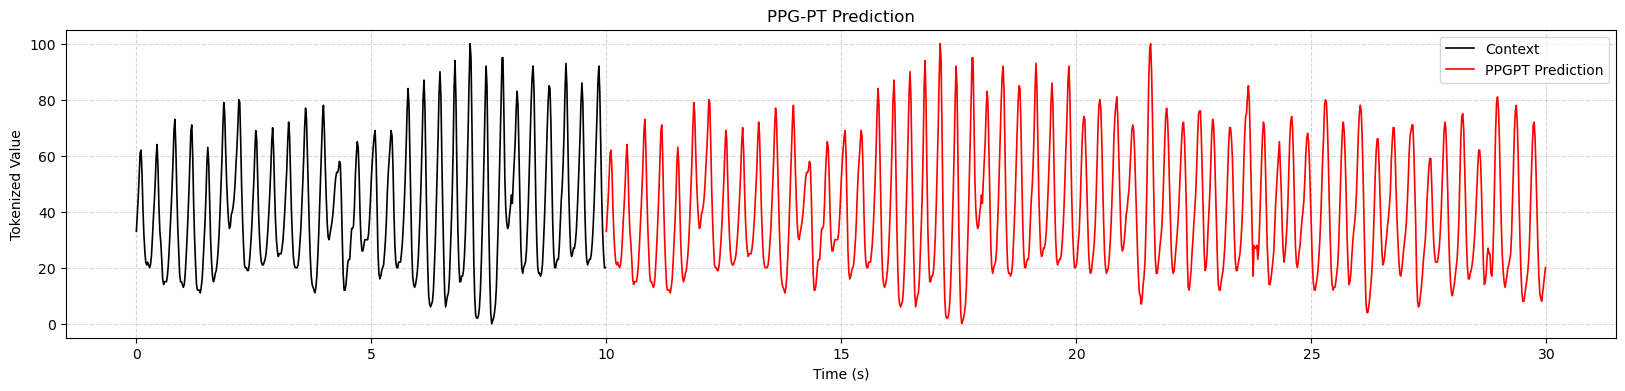

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 모델 설정
model_config = 'PPG_PT'  # 'PPG_PT' 또는 'ECG_PT' 선택

block_size = 500  # 컨텍스트 길이
n_embd = 64
n_head = 8
n_layer = 8
dropout = 0.2
model_path_ppg = "PPGPT_500k_iters.pth"
model_path_ecg = "ECGPT_560k_iters.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if model_config == 'PPG_PT':
    vocab_size = 102  # PPG 모델
    model_path = model_path_ppg
elif model_config == 'ECG_PT':
    vocab_size = 101  # ECG 모델
    model_path = model_path_ecg


# 2. 데이터 전처리 함수 (정규화 및 토큰화)
def tokenize_biosignal(data):
    if isinstance(data, list): 
        data = np.array(data)
    if len(data.shape) == 1:
        data = data.reshape(1, -1)

    # 정규화 (0~1 범위)
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)

    # 0~100 정수 변환
    data_scaled *= 100
    data_rounded = np.round(data_scaled).astype(int)

    return data_rounded


# 3. HeartGPT 모델 클래스 정의
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((block_size, block_size))))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k, q, v = self.key(x), self.query(x), self.value(x)
        wei = (q @ k.transpose(-2, -1)) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class Heart_GPT_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# 4. 모델 로드 및 초기화
model = Heart_GPT_Model()
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)


# 5. 데이터 로드 및 전처리
file_path = "ppg_data2.csv"
df = pd.read_csv(file_path)
# 데이터 변환
ppg_data = df["ppg_data"].values.reshape(1, -1)
tokenized_ppg = tokenize_biosignal(ppg_data)
example_context_tensor = torch.tensor(tokenized_ppg, dtype=torch.long, device=device)


# 6. 모델을 사용하여 새로운 데이터 생성
generated_tokens = model.generate(example_context_tensor, max_new_tokens=500)[0].tolist()


# 7. 생성된 데이터 저장
output_df = pd.DataFrame(generated_tokens, columns=["generated_data"])
output_path = "GPT_model_output.csv"
output_df.to_csv(output_path, index=False)
print(f"생성된 데이터 저장 완료: {output_path}")

sampling_rate = 50
original_time = np.arange(len(tokenized_ppg[0])) / sampling_rate
generated_time = np.arange(len(tokenized_ppg[0]), len(tokenized_ppg[0]) + len(generated_tokens)) / sampling_rate

plt.figure(figsize=(20, 4))
plt.plot(original_time, tokenized_ppg[0], label="Context", color="black", linewidth=1.2)
plt.plot(generated_time, generated_tokens, label="PPGPT Prediction", color="red", linewidth=1.2)
plt.xlabel("Time (s)")
plt.ylabel("Tokenized Value")
plt.title("PPG-PT Prediction")
plt.grid(True, linestyle="--", alpha=0.5) 
plt.legend()
plt.show()